### Import all the relevant libraries and read in dataset

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  
import pandas as pd
import numpy as np
import scipy.stats as stats
import chardet
import ast
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot

# # Detect encoding
# with open('combined_data.csv', 'rb') as f:
#     result = chardet.detect(f.read())
#     encoding = result['encoding']

# print(f"Detected encoding: {encoding}")

# Now use the detected encoding to read the CSV
df = pd.read_csv('combined_listings.csv')
df.fillna(0, inplace=True)
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df_HongKong = df[df['City'] == 'Hong Kong'];
df_NewYork = df[df['City'] == 'New York'];
df_Mexico_City = df[df['City'] == 'Mexico City'];
df_Paris = df[df['City'] == 'Paris'];
df_Rio = df[df['City'] == 'Rio de Janeiro'];
df_Tokyo = df[df['City'] == 'Tokyo'];

<>:25: SyntaxWarning: invalid escape sequence '\$'
<>:25: SyntaxWarning: invalid escape sequence '\$'
C:\Users\leeze\AppData\Local\Temp\ipykernel_26740\1813814320.py:25: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)


### Group the list of amenities into categories

In [4]:
# Convert string lists into Python lists
df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Define a dictionary to map amenity keywords to broader categories
category_mapping = {
    'toilet equipping/ toiletries': [
        'soap', 'shampoo', 'conditioner', 'towel', 'toothpaste', 'toothbrush', 'body wash', 'lotion',
        'shower gel', 'bath', 'hand sanitizer', 'hair', 'hair dryer', 'toilet', 'toilet paper', 'bath', 'bathroom essentials',
        'bath tub', 'shower', 'water', 'robe', 'bidet'
    ],
    'kitchen appliances': [
        'microwave', 'oven', 'stove', 'refrigerator', 'fridge', 'freezer', 'toaster', 
        'coffee maker', 'kettle', 'blender', 'dishwasher', 'wine glasses', 'cooking', 
        'kitchenware', 'pots', 'pans', 'cutlery', 'dishes', 'silverware', 'utensils', 'cups',
        'mugs', 'glasses', 'opener', 'corkscrew', 'grill', 'barbecue', 'cooker', 'food processor',
        'juicer', 'mixer', 'waffle maker', 'fondue set', 'bread maker', 'sink'
    ],
    'housekeeping': [
        'cleaning', 'laundry', 'washer', 'dryer', 'ironing board', 'iron', 'vacuum', 
        'broom', 'mop', 'housekeeping', 'keeping', 'laundromat', 'extra linens', 'cleaning', 'cleaning products',
        'detergent', 'basket', 'rack'
    ],
    'entertainment': [
        'tv', 'wifi', 'internet', 'cable', 'satellite', 'netflix', 'blu-ray', 'streaming', 
        'gaming console', 'hdtv', 'sound system', 'speakers', 'dvd player', 'hdmi',
        'connection', 'board games', 'video games', 'music', 'movies', 'books', 'magazines',
        'puzzles', 'toys', 'video library', 'game console', 'cd player', 'vinyl player',
        'record player', 'karaoke', 'projector', 'home theater', 'smart tv', 'chromecast',
        'arcade', 'playground'
    ],
    'comfort': [
        'central heating', 'portable heater', 'heating', 'heater', 'heated', 'air conditioning', 'ac', 'aircon', 'cooling', 'fan', 'ceiling fan',
        'blanket', 'pillow', 'bed', 'mattress', 'shades', 'curtains', 'extra pillows', 'extra blankets', 'quilts', 'duvet', 'comforter', 'linens',
        'split-type ductless system', 'slippers', 'heated floors', 'heated towel rack', 'fireplace', 'wood stove', 'radiators',
        'electric blanket', 'heated mattress pad'
    ],
    'safety': [
        'smoke alarm', 'carbon monoxide alarm', 'alarm', 'fire extinguisher', 'first aid kit', 
        'safe', 'lockbox', 'security', 'cameras', 'security system', 'surveillance', 'emergency kit', 'fire blanket',
        'fire escape', 'fire safety', 'fire sprinklers', 'smart lock', 'door lock', 'lock', 'window lock', 
        'safety', 'safety card', 'safety instructions', 'safety manual', 'guard', 'patrol', 'monitoring', 'cctv'
    ],
    'accessibility': [
        'elevator', 'wheelchair accessible', 'ramp', 'step-free', 'wide doorway', 'accessible bathroom', 'grab bars', 'lowered sink', 
        'mobility', 'accessibility features', 'wide', 'accessible', 'disabled', 'handicap'
    ],
    'outdoor': [
        'car park', 'carpark', 'parking', 'garage', 'street parking', 'patio', 'balcony', 'backyard', 'garden', 
        'bbq grill', 'terrace', 'outdoor seating', 'fire pit', 'bicycle', 'hiking', 'outdoor dining',
        'outdoor shower', 'outdoor kitchen', 'outdoor furniture', 'outdoor games', 'outdoor space',
        'outdoor grill', 'outdoor fireplace', 'outdoor pool', 'outdoor hot tub', 'outdoor bar',
        'outdoor lighting', 'outdoor living', 'outdoor cinema', 'outdoor gym', 'outdoor yoga'
    ],
    'special amenities': [
        'hot tub', 'pool', 'jacuzzi', 'gym', 'sauna', 'game room', 'wine cooler', 'piano', 'pool table', 'library', 'spa', 'steam room',
        'yoga studio', 'golf course', 'tennis court', 'basketball court', 'volleyball court', 'soccer field', 'football field', 'baseball field', 
        'badminton court', 'squash court', 'court', 'table tennis', 'ping pong', 'billiards', 'darts', 'foosball', 'air hockey', 'lawn games', 'trampoline'
    ],
    'workspace': [
        'work', 'desk', 'office', 'laptop friendly', 'printer', 'scanner', 
        'meeting', 'office chair', 'ergonomic', 'reading', 'study'
    ]
}

# Function to categorize amenities
def categorize_amenities(amenity_list):
    categories = set()
    for amenity in amenity_list:
        for category, keywords in category_mapping.items():
            if any(keyword.lower() in amenity.lower() for keyword in keywords):
                categories.add(category)
    return list(categories) if categories else ['others']

# Apply the function to categorize the amenities for each row
df['amenity_categories'] = df['amenities'].apply(categorize_amenities)

# Display the data with categorized amenities
print(df[['amenities', 'amenity_categories']])

                                                amenities  \
0       [Extra pillows and blankets, Heating, Kitchen,...   
1       [Dishes and silverware, Washer, Dryer, Air con...   
2       [Washer, Clothing storage: wardrobe, Kitchen, ...   
3       [Extra pillows and blankets, Washer, Heating, ...   
4       [Washer, Air conditioning, Dryer, TV, Kitchen,...   
...                                                   ...   
217342  [Bed linens, Self check-in, Bathtub, Toaster, ...   
217343  [Smoke alarm, Air conditioning, Washer, Carbon...   
217344  [Smoke alarm, Smart lock, Air conditioning, Se...   
217345  [Smoke alarm, Air conditioning, Self check-in,...   
217346  [Bed linens, Bathtub, Toaster, Ethernet connec...   

                                       amenity_categories  
0       [housekeeping, safety, entertainment, accessib...  
1       [housekeeping, workspace, outdoor, special ame...  
2       [housekeeping, entertainment, accessibility, c...  
3       [housekeeping, safe

### Display the list of amenities categories

In [5]:
# # Convert string lists into Python lists
# df['amenity_categories'] = df['amenity_categories'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the list of amenities across all rows into one single list
amenities_category = [amenity for sublist in df['amenity_categories'] for amenity in sublist]

# Get the unique amenities
unique_category = set(amenities_category)   
# Display the full list of unique amenities
print("Unique Amenities:", unique_category)
print(len(unique_category))

# Create dummy columns for each unique amenity
for category in unique_category:
    df[category] = df['amenity_categories'].apply(lambda x: 1 if category in x else 0)

# Calculate the total number of amenity categories for each listing
df['total_amenity_categories'] = df[list(unique_category)].sum(axis=1)

# Display the updated dataframe with total number of amenity categories
print(df[['amenity_categories', 'total_amenity_categories']].head())

Unique Amenities: {'housekeeping', 'safety', 'workspace', 'outdoor', 'special amenities', 'others', 'entertainment', 'accessibility', 'comfort', 'kitchen appliances', 'toilet equipping/ toiletries'}
11
                                  amenity_categories  total_amenity_categories
0  [housekeeping, safety, entertainment, accessib...                         7
1  [housekeeping, workspace, outdoor, special ame...                         8
2  [housekeeping, entertainment, accessibility, c...                         6
3  [housekeeping, safety, workspace, outdoor, spe...                         9
4  [comfort, housekeeping, entertainment, accessi...                         4


### Count of each amenity category and across cities

In [6]:
# # Convert string lists into Python lists
# df['amenity_categories'] = df['amenity_categories'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Count the number of listings for each unique amenity category
category_counts = df['amenity_categories'].explode().value_counts()

# Sort the categories alphabetically, excluding 'others'
sorted_categories = sorted([cat for cat in category_counts.index if cat != 'others'])
sorted_categories.append('others')

# Reindex the series to match the sorted categories
sorted_category_counts = category_counts.reindex(sorted_categories)

# Plot the data
import plotly.express as px

# Create the bar plot using Plotly
fig = px.bar(
    x=sorted_category_counts.index,
    y=sorted_category_counts.values,
    labels={'x': 'Amenity Categories', 'y': 'Number of Listings'},
    title='Number of Listings by Amenity Categories'
)

# Customize the layout for better readability
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title='Amenity Categories',
    yaxis_title='Number of Listings',
    title='Number of Listings by Amenity Categories',
    height=600,
    width=800
)

# # Show the plot
# fig.show()
# sns.barplot(x=sorted_category_counts.index, y=sorted_category_counts.values)
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Amenity Categories')
# plt.ylabel('Number of Listings')
# plt.title('Number of Listings by Amenity Categories')
# plt.show()

In [7]:
# Group by City and Amenities Category and count occurrences

# Explode the 'amenity_categories' so each row contains only one amenity
df_exploded = df.explode('amenity_categories')

amenities_count = df_exploded.groupby(['City', 'amenity_categories']).size().reset_index(name='count')

# Filter out the 'others' category
amenities_count = amenities_count[amenities_count['amenity_categories'] != 'others']

# Set the plot size
plt.figure(figsize=(15, 8))
import plotly.express as px

# Create the bar plot using Plotly
fig = px.bar(
    amenities_count,
    x='amenity_categories',
    y='count',
    color='City',
    labels={'amenity_categories': 'Amenity Categories', 'count': 'Count'},
    title='Count of Each Amenity Category per City'
)

# Customize the layout for better readability
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title='Amenity Categories',
    yaxis_title='Count',
    title='Count of Each Amenity Category per City',
    height=600,
    width=800
)

# # Show the plot
# fig.show()
# # Create the bar plot for the count of amenities per city
# sns.barplot(x='amenity_categories', y='count', hue='City', data=amenities_count)

# # Customize the plot
# plt.title('Count of Each Amenity Category per City')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
# plt.xlabel('Amenity Categories')
# plt.ylabel('Count')
# plt.legend(title='City')
# plt.tight_layout()

# # Show the plot
# plt.show()

<Figure size 1500x800 with 0 Axes>

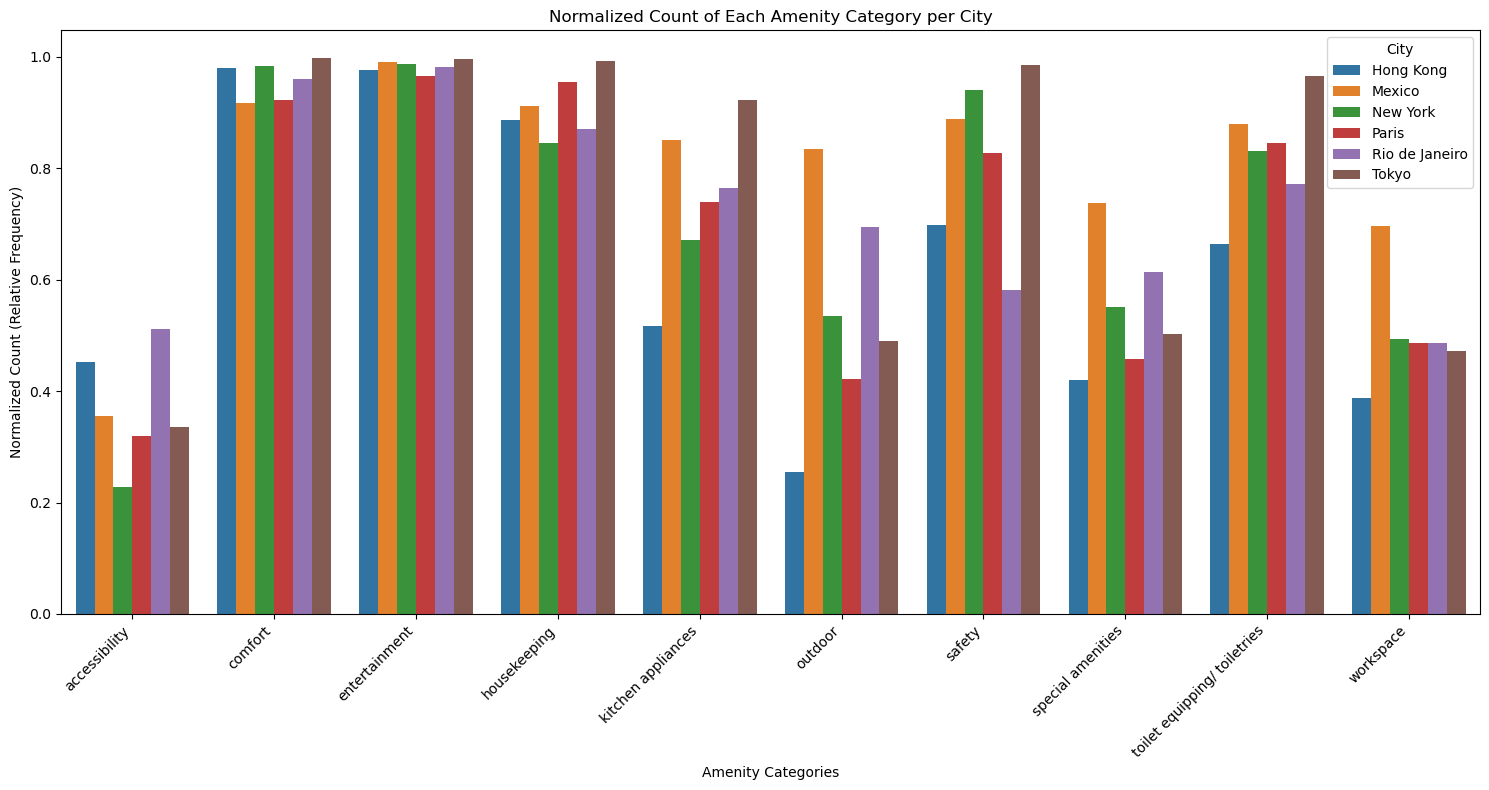

In [8]:
# Set the plot size

# Calculate the total number of listings per city
total_listings_per_city = df['City'].value_counts()

# Merge the total listings with the amenities count
amenities_count = amenities_count.merge(total_listings_per_city.rename('total_listings'), left_on='City', right_index=True)

# Calculate the normalized count
amenities_count['normalized_count'] = amenities_count['count'] / amenities_count['total_listings']
plt.figure(figsize=(15, 8))

# Create the bar plot for the normalized count of amenities per city
sns.barplot(x='amenity_categories', y='normalized_count', hue='City', data=amenities_count)

# Customize the plot
plt.title('Normalized Count of Each Amenity Category per City')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel('Amenity Categories')
plt.ylabel('Normalized Count (Relative Frequency)')
plt.legend(title='City')
plt.tight_layout()

# Show the plot
plt.show()


### Convert prices to SGD

In [9]:
# Step 1: Ensure 'price' is treated as a string for cleaning
df['price'] = df['price'].astype(str)

# Step 2: Remove non-numeric characters ($ sign, commas) and strip spaces
df['price_cleaned'] = df['price'].str.replace(r'[\$,]', '', regex=True)  # Remove $ signs and commas
df['price_cleaned'] = df['price_cleaned'].str.strip()                    # Remove extra spaces if any

# Step 3: Convert the cleaned price to numeric (float)
df['price_cleaned'] = pd.to_numeric(df['price_cleaned'], errors='coerce')  # Convert to float, invalid to NaN

# Step 4: Check the cleaned prices
print(df[['price', 'price_cleaned']])

# Check for any NaN values
print("Number of NaN values in 'price_cleaned':", df['price_cleaned'].isnull().sum())

          price  price_cleaned
0         800.0          800.0
1       22297.0        22297.0
2         819.0          819.0
3         959.0          959.0
4        1001.0         1001.0
...         ...            ...
217342  16000.0        16000.0
217343   4714.0         4714.0
217344  13186.0        13186.0
217345  10400.0        10400.0
217346  31314.0        31314.0

[217347 rows x 2 columns]
Number of NaN values in 'price_cleaned': 0


In [10]:
# Define exchange rates (approximate as of recent values)
exchange_rates = {
    'Hong Kong': 0.1670,        # HKD to SGD
    'Mexico City': 0.076,     # MXN to SGD
    'New York': 1.36,          # USD to SGD
    'Paris': 1.62,            # EUR to SGD
    'Rio De Janeiro': 0.24,   # BRL to SGD
    'Tokyo': 0.0088           # JPY to SGD
}

# Function to clean and convert prices to USD based on city
def convert_to_sgd(row):
    city = row['City']
    price_in_local_currency = row['price_cleaned']
    
    # Check if the price is a string and clean up '$' and commas
    if isinstance(price_in_local_currency, str):
        # Remove any '$' signs and commas
        price_in_local_currency = price_in_local_currency.replace('$', '').replace(',', '')
    
    # Convert the cleaned price to float
    try:
        price_in_local_currency = float(price_in_local_currency)
    except ValueError:
        return None  # Return None for rows where conversion fails

    # Get the conversion rate for the city
    conversion_rate = exchange_rates.get(city, 1)  # Default to 1 if city is not found (USD assumed)

    # Return the price converted to USD
    return price_in_local_currency * conversion_rate

# Apply the conversion to each row
df['price_sgd'] = df.apply(convert_to_sgd, axis=1)

# Now you can use 'price_usd' for all comparisons, as all prices are in USD
# print(df[['City', 'price', 'price_sgd']].head())
# print(df[['City', 'price', 'price_sgd']].tail())

# Check for NaN values after conversion (in case of failed conversions)
print("Number of NaN values in 'price_sgd':", df['price_sgd'].isnull().sum())
print(df['City'].value_counts())

# Optionally drop rows with NaN prices if needed
df_cleaned = df.dropna(subset=['price_sgd'])


Number of NaN values in 'price_sgd': 0
City
Paris             95461
New York          37541
Rio de Janeiro    34664
Mexico            26536
Tokyo             16518
Hong Kong          6627
Name: count, dtype: int64


### Inferential Analysis on 4 Common Categories

#### Descriptive Analysis on the 4 Common Categories

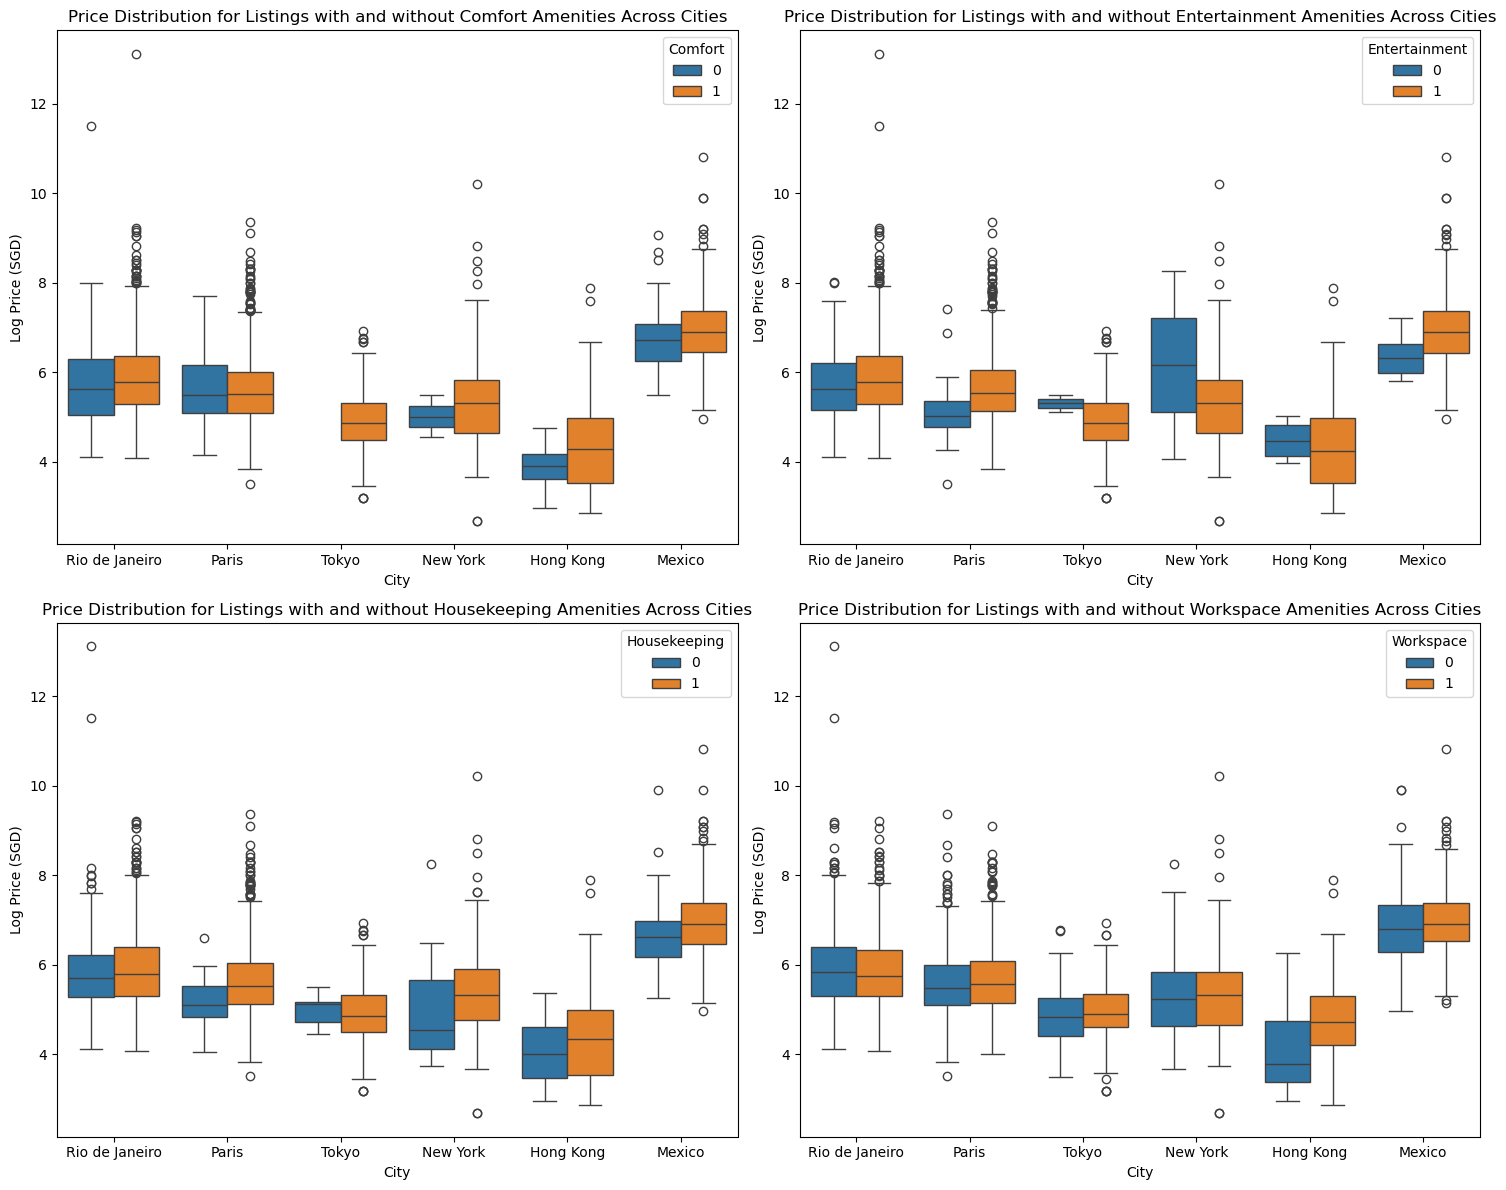

In [11]:
# Take a random sample of 5000 rows from the dataset
df_sample = df_cleaned.sample(n=5000, random_state=42)

# Filter out listings with price_sgd < 10
df_sample = df_sample[df_sample['price_sgd'] >= 10]

# Apply log transformation to the price column
df_sample['log_price_sgd'] = np.log(df_sample['price_sgd'] + 1)  # Add 1 to avoid log(0)

# Set up the matplotlib figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# List of categories to plot
categories = ['comfort', 'entertainment', 'housekeeping', 'workspace']

# Plot each category in a separate subplot
for ax, category in zip(axes.flatten(), categories):
    sns.boxplot(x='City', y='log_price_sgd', hue=category, data=df_sample, ax=ax)
    ax.set_title(f'Price Distribution for Listings with and without {category.capitalize()} Amenities Across Cities')
    ax.set_xlabel('City')
    ax.set_ylabel('Log Price (SGD)')
    ax.legend(title=category.capitalize(), loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

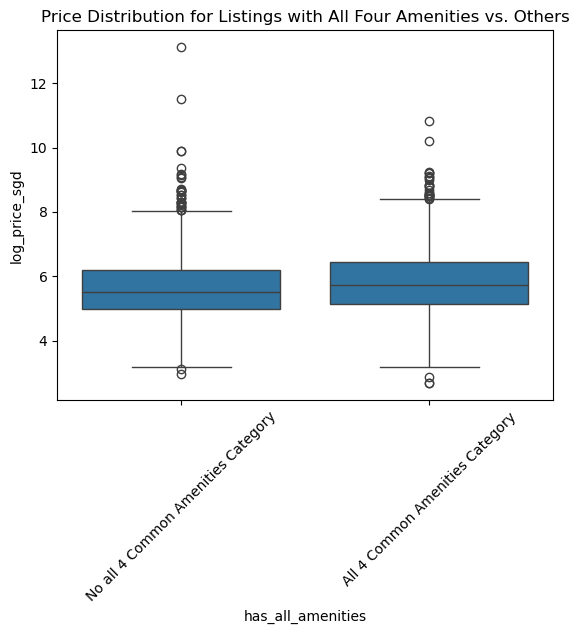

In [12]:
# Create a combined amenities indicator
df_sample['combined_amenities'] = df_sample[['comfort', 'entertainment', 'housekeeping', 'workspace']].sum(axis=1)
df_sample['has_all_amenities'] = df_sample['combined_amenities'].apply(lambda x: 1 if x == 4 else 0)

# Plot price distribution for listings with and without all four amenities
sns.boxplot(x='has_all_amenities', y='log_price_sgd', data=df_sample)
plt.title('Price Distribution for Listings with All Four Amenities vs. Others')
plt.xticks([0, 1], ['No all 4 Common Amenities Category', 'All 4 Common Amenities Category'], rotation=45)
plt.show()

#### T-test to determine if the difference in prices between listings with all 4 amenities and those without is statistically significant

In [13]:
# Perform t-test for price difference
group_with_amenities = df_sample[df_sample['has_all_amenities'] == 1]['log_price_sgd']
group_without_amenities = df_sample[df_sample['has_all_amenities'] == 0]['log_price_sgd']

t_stat, p_val = stats.ttest_ind(group_with_amenities, group_without_amenities)

# Define significance level (alpha)
alpha = 0.05

# Formulating Hypotheses
print("Hypotheses:")
print("H₀: There is no significant difference in the prices between listings with all amenities and those without.")
print("H₁: There is a significant difference in the prices between listings with all amenities and those without.\n")

# Print test statistics
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

# Draw conclusion based on the p-value
if p_val < alpha:
    print(f"\nConclusion: Since the p-value ({p_val:.4f}) is less than the significance level of {alpha}, we reject the null hypothesis (H₀).")
    print("There is significant evidence to suggest that having all four amenities results in a different price compared to listings without them.")
else:
    print(f"\nConclusion: Since the p-value ({p_val:.4f}) is greater than the significance level of {alpha}, we fail to reject the null hypothesis (H₀).")
    print("There is no significant evidence to suggest that having all four amenities results in a different price compared to listings without them.")

Hypotheses:
H₀: There is no significant difference in the prices between listings with all amenities and those without.
H₁: There is a significant difference in the prices between listings with all amenities and those without.

T-statistic: 6.7483
P-value: 0.0000

Conclusion: Since the p-value (0.0000) is less than the significance level of 0.05, we reject the null hypothesis (H₀).
There is significant evidence to suggest that having all four amenities results in a different price compared to listings without them.


#### Two-way ANOVA to determine if there is significant effect of city and having all 4 amenities on prices, and whether there is significant interaction between city and amenities

In [14]:
# Step 1: Create the model with City and Has_All_Amenities as independent factors
model = ols('log_price_sgd ~ C(City) + C(has_all_amenities) + C(City):C(has_all_amenities)', data=df_sample).fit()

# Step 2: Perform Two-Way ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Step 3: Print the ANOVA table
print(anova_table)

# Step 4: Define the hypotheses and interpret results

# Hypotheses:
print("\nHypotheses:")
print("1. Main Effect of City:")
print("   H₀: There is no significant difference in prices between cities.")
print("   H₁: There is a significant difference in prices between cities.\n")

print("2. Main Effect of Amenities (Has All Amenities):")
print("   H₀: There is no significant difference in prices between listings with and without all four amenities.")
print("   H₁: There is a significant difference in prices between listings with and without all four amenities.\n")

print("3. Interaction Effect (City * Amenities):")
print("   H₀: There is no interaction effect between city and amenities on prices.")
print("   H₁: There is an interaction effect between city and amenities on prices.\n")

# Step 5: Extract p-values from ANOVA table
p_value_city = anova_table.loc['C(City)', 'PR(>F)']
p_value_amenities = anova_table.loc['C(has_all_amenities)', 'PR(>F)']
p_value_interaction = anova_table.loc['C(City):C(has_all_amenities)', 'PR(>F)']

# Step 6: Set significance level (alpha)
alpha = 0.05

# Step 7: Conclusion for City
if p_value_city < alpha:
    print(f"Conclusion for City: The p-value for city ({p_value_city:.4f}) is less than {alpha}.")
    print("Reject H₀. There is significant evidence that prices differ between cities.\n")
else:
    print(f"Conclusion for City: The p-value for city ({p_value_city:.4f}) is greater than {alpha}.")
    print("Fail to reject H₀. There is no significant evidence that prices differ between cities.\n")

# Step 8: Conclusion for Amenities (Has All Amenities)
if p_value_amenities < alpha:
    print(f"Conclusion for Amenities: The p-value for amenities ({p_value_amenities:.4f}) is less than {alpha}.")
    print("Reject H₀. There is significant evidence that prices differ based on whether listings have all four amenities.\n")
else:
    print(f"Conclusion for Amenities: The p-value for amenities ({p_value_amenities:.4f}) is greater than {alpha}.")
    print("Fail to reject H₀. There is no significant evidence that prices differ based on whether listings have all four amenities.\n")

# Step 9: Conclusion for Interaction Effect (City * Amenities)
if p_value_interaction < alpha:
    print(f"Conclusion for Interaction: The p-value for interaction ({p_value_interaction:.4f}) is less than {alpha}.")
    print("Reject H₀. There is significant evidence that the effect of amenities on prices depends on the city (interaction effect).\n")
else:
    print(f"Conclusion for Interaction: The p-value for interaction ({p_value_interaction:.4f}) is greater than {alpha}.")
    print("Fail to reject H₀. There is no significant evidence of an interaction effect between city and amenities on prices.\n")


                                   sum_sq      df           F        PR(>F)
C(City)                       1432.115521     5.0  440.929560  0.000000e+00
C(has_all_amenities)            12.859477     1.0   19.796321  8.861299e-06
C(City):C(has_all_amenities)    23.558947     5.0    7.253490  9.029177e-07
Residual                      2471.687111  3805.0         NaN           NaN

Hypotheses:
1. Main Effect of City:
   H₀: There is no significant difference in prices between cities.
   H₁: There is a significant difference in prices between cities.

2. Main Effect of Amenities (Has All Amenities):
   H₀: There is no significant difference in prices between listings with and without all four amenities.
   H₁: There is a significant difference in prices between listings with and without all four amenities.

3. Interaction Effect (City * Amenities):
   H₀: There is no interaction effect between city and amenities on prices.
   H₁: There is an interaction effect between city and amenities on 

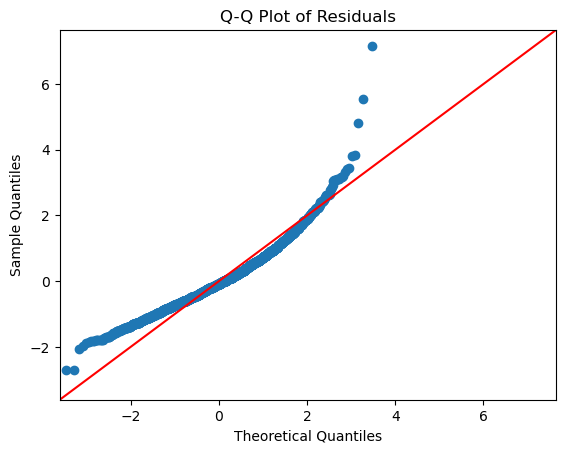

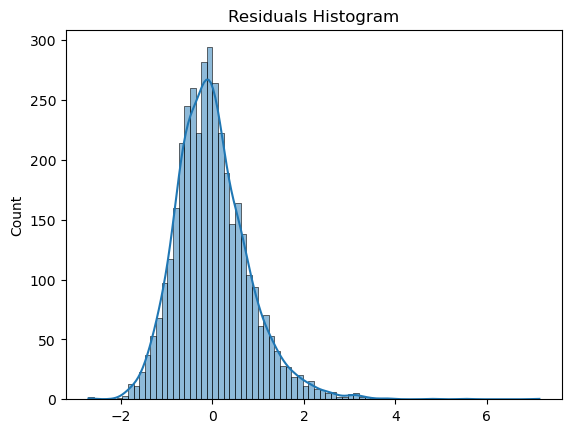

In [15]:
# Get residuals from the ANOVA model
residuals = model.resid

# Q-Q plot for residuals
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Plot a histogram of residuals
sns.histplot(residuals, kde=True)
plt.title('Residuals Histogram')
plt.show()

#### Tukey test to determine which specific city-amenity combinations differ significantly in terms of prices

In [16]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Step 1: Perform Tukey's HSD test on city-amenity combinations
df_sample['city_amenities'] = df_sample['City'].astype(str) + "_" + df_sample['has_all_amenities'].astype(str)

# Run the Tukey HSD test
tukey = pairwise_tukeyhsd(endog=df_sample['log_price_sgd'], groups=df_sample['city_amenities'], alpha=0.05)

# Step 2: Print Tukey's HSD Summary
print(tukey.summary())

# Step 3: Define and explain hypotheses
print("\nTukey's HSD Hypotheses:")
print("H₀: There is no significant difference in mean prices between pairs of city-amenity combinations.")
print("H₁: There is a significant difference in mean prices between at least one pair of city-amenity combinations.\n")

# Step 4: Extract Tukey's results into a DataFrame for easier analysis
tukey_results_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

# Inspect the first few rows to check the structure
print(tukey_results_df.head())

# Step 5: Loop through each comparison and interpret results
for i, row in tukey_results_df.iterrows():
    group1 = row['group1']
    group2 = row['group2']
    mean_diff = row['meandiff']
    p_value = row['p-adj']
    reject = row['reject']  # This is boolean, not string
    
    # Print the comparison details
    print(f"Comparing: {group1} vs {group2}")
    print(f"   Mean Difference: {mean_diff}")
    print(f"   P-value: {p_value}")
    
    # Step 6: Conclusion based on p-value (reject is a boolean, so we compare with True/False)
    if reject:
        print(f"   Conclusion: Reject H₀. There is a significant difference in prices between {group1} and {group2}.\n")
    else:
        print(f"   Conclusion: Fail to reject H₀. No significant difference in prices between {group1} and {group2}.\n")


          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
     Hong Kong_0      Hong Kong_1   0.7751    0.0   0.324  1.2261   True
     Hong Kong_0         Mexico_0   2.7857    0.0  2.4413  3.1301   True
     Hong Kong_0         Mexico_1   2.9355    0.0  2.6161  3.2549   True
     Hong Kong_0       New York_0   1.1175    0.0  0.7743  1.4606   True
     Hong Kong_0       New York_1   1.3399    0.0   1.013  1.6668   True
     Hong Kong_0          Paris_0   1.5177    0.0  1.2115  1.8238   True
     Hong Kong_0          Paris_1   1.6303    0.0   1.326  1.9346   True
     Hong Kong_0 Rio de Janeiro_0   1.9236    0.0  1.6064  2.2408   True
     Hong Kong_0 Rio de Janeiro_1   1.8466    0.0  1.5262   2.167   True
     Hong Kong_0          Tokyo_0   0.8156    0.0  0.4659  1.1652   True
     Hong Kong_0          Tokyo_1   0.9322    0.0  

### Inferential Analysis on Basic and Basic + Premium Amenities Category

                  count      mean       std       min       25%       50%  \
amenity_group                                                               
Basic + Premium  2891.0  5.844594  1.008725  2.681022  5.123964  5.711486   
Basic Only        926.0  5.403047  0.984668  2.963725  4.856315  5.377406   

                      75%        max  
amenity_group                         
Basic + Premium  6.475433  10.819798  
Basic Only       5.923186  13.122365  


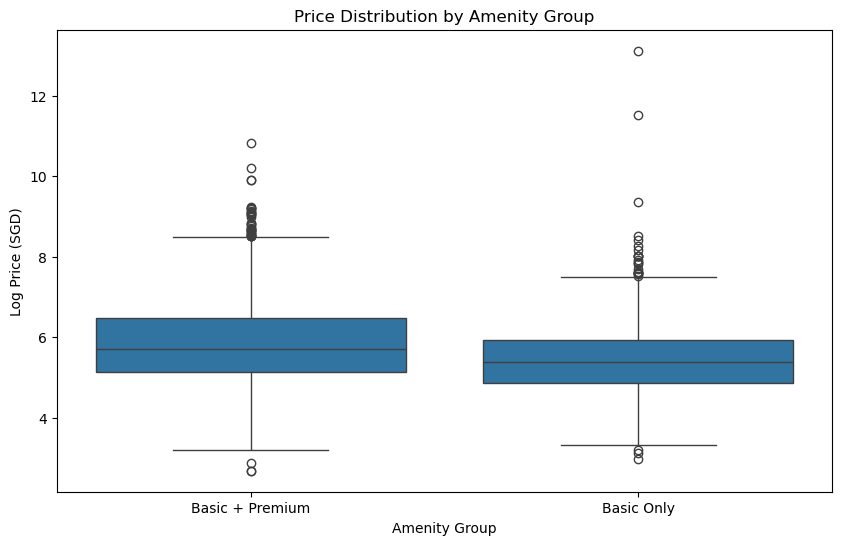

In [17]:
# Data Preparation
# Create new columns indicating whether listings have basic or premium amenities
df_sample['has_basic_amenities'] = (df_sample['comfort'] == 1) & (df_sample['entertainment'] == 1) & (df_sample['housekeeping'] == 1) & (df_sample['workspace'] == 1)
df_sample['has_premium_amenities'] = (df_sample['outdoor'] == 1) | (df_sample['special amenities'] == 1)

# Create a new column combining both
df_sample['amenity_group'] = np.where(df_sample['has_premium_amenities'], 'Basic + Premium', 'Basic Only')

# Descriptive Statistics
# Calculate summary statistics for both groups
summary_stats = df_sample.groupby('amenity_group')['log_price_sgd'].describe()
print(summary_stats)

# Step 3: Visualization
# Boxplot of price by amenity group
plt.figure(figsize=(10, 6))
sns.boxplot(x='amenity_group', y='log_price_sgd', data=df_sample)
plt.title('Price Distribution by Amenity Group')
plt.xlabel('Amenity Group')
plt.ylabel('Log Price (SGD)')
plt.show()


#### T-test to determine if the difference in prices between listings with Basic + Premium amenities and those with Basic only amenities is statistically significant

In [18]:
# T-test
# Compare the mean prices between the two groups
basic_only = df_sample[df_sample['amenity_group'] == 'Basic Only']['log_price_sgd']
basic_premium = df_sample[df_sample['amenity_group'] == 'Basic + Premium']['log_price_sgd']

t_stat, p_value = stats.ttest_ind(basic_only, basic_premium, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")
if p_value < 0.05:
    print("Conclusion: Reject H₀. There is a significant difference in prices between the two amenity groups.")
else:
    print("Conclusion: Fail to reject H₀. No significant difference in prices between the two amenity groups.")

T-statistic: -11.80497417536906, P-value: 6.831083969199176e-31
Conclusion: Reject H₀. There is a significant difference in prices between the two amenity groups.


#### Two-way ANOVA to determine if there is significant effect of city and having Basic + Premium/ Basic only amenities on prices, and whether there is significant interaction between city and amenities

In [19]:
# Perform Two-Way ANOVA
# Define the model
model = ols('log_price_sgd ~ C(City) + C(amenity_group) + C(City):C(amenity_group)', data=df_sample).fit()

# ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Table:")
print(anova_table)

# Define and explain hypotheses for ANOVA
print("\nANOVA Hypotheses:")
print("For City Effect:")
print("H₀: There is no significant difference in prices between cities.")
print("H₁: There is a significant difference in prices between cities.\n")

print("For Amenity Group Effect:")
print("H₀: There is no significant difference in prices between listings with 'Basic Only' and 'Basic + Premium' amenities.")
print("H₁: There is a significant difference in prices between the two amenity groups.\n")

print("For Interaction Effect (City x Amenities):")
print("H₀: There is no interaction effect between city and amenities on prices.")
print("H₁: There is an interaction effect between city and amenities on prices.\n")

# Interpret the ANOVA results
print("ANOVA Conclusion:")
if anova_table['PR(>F)']['C(City)'] < 0.05:
    print("For City: Reject H₀. There is a significant difference in prices between cities.")
else:
    print("For City: Fail to reject H₀. There is no significant difference in prices between cities.")

if anova_table['PR(>F)']['C(amenity_group)'] < 0.05:
    print("For Amenities: Reject H₀. There is a significant difference in prices between the two amenity groups.")
else:
    print("For Amenities: Fail to reject H₀. There is no significant difference in prices between the two amenity groups.")

if anova_table['PR(>F)']['C(City):C(amenity_group)'] < 0.05:
    print("For Interaction: Reject H₀. There is a significant interaction effect between city and amenities on prices.")
else:
    print("For Interaction: Fail to reject H₀. There is no significant interaction effect between city and amenities on prices.")

ANOVA Table:
                               sum_sq      df           F        PR(>F)
C(City)                   1352.296945     5.0  418.328159  0.000000e+00
C(amenity_group)            22.898366     1.0   35.417633  2.901038e-09
C(City):C(amenity_group)    25.181578     5.0    7.789830  2.646298e-07
Residual                  2460.025591  3805.0         NaN           NaN

ANOVA Hypotheses:
For City Effect:
H₀: There is no significant difference in prices between cities.
H₁: There is a significant difference in prices between cities.

For Amenity Group Effect:
H₀: There is no significant difference in prices between listings with 'Basic Only' and 'Basic + Premium' amenities.
H₁: There is a significant difference in prices between the two amenity groups.

For Interaction Effect (City x Amenities):
H₀: There is no interaction effect between city and amenities on prices.
H₁: There is an interaction effect between city and amenities on prices.

ANOVA Conclusion:
For City: Reject H₀. There is

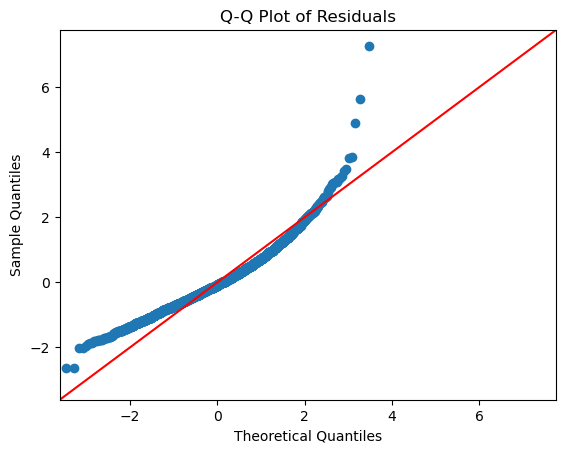

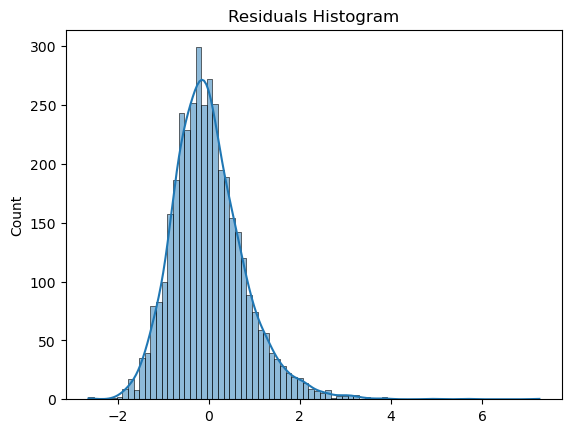

In [20]:
# Get residuals from the ANOVA model
residuals = model.resid

# Q-Q plot for residuals
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Plot a histogram of residuals
sns.histplot(residuals, kde=True)
plt.title('Residuals Histogram')
plt.show()

#### Tukey test to determine which specific city-amenity combinations differ significantly in terms of prices

In [21]:
# Step 1: Perform Tukey's HSD test on city-amenity combinations
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assuming df_sample_clean contains the relevant columns for analysis
tukey = pairwise_tukeyhsd(endog=df_sample['log_price_sgd'], groups=df_sample['city_amenities'], alpha=0.05)

# Step 2: Print Tukey's HSD Summary
print(tukey.summary())

# Step 3: Define and explain hypotheses
print("\nTukey's HSD Hypotheses:")
print("H₀: There is no significant difference in mean prices between pairs of city-amenity combinations.")
print("H₁: There is a significant difference in mean prices between at least one pair of city-amenity combinations.\n")

# Step 4: Extract Tukey's results into a DataFrame for easier analysis
tukey_results_df = pd.DataFrame(data=tukey._results_table.data[1:], 
                                columns=tukey._results_table.data[0])

# Step 5: Loop through each comparison and interpret results
for i, row in tukey_results_df.iterrows():
    group1 = row['group1']
    group2 = row['group2']
    mean_diff = row['meandiff']
    p_value = float(row['p-adj'])
    reject = row['reject']
    
    # Print the comparison details
    print(f"Comparing: {group1} vs {group2}")
    print(f"   Mean Difference: {mean_diff}")
    print(f"   P-value: {p_value}")
    
    # Step 6: Conclusion based on reject status
    if reject == 'True' or reject is True:
        print(f"   Conclusion: Reject H₀. There is a significant difference in prices between {group1} and {group2}.\n")
    else:
        print(f"   Conclusion: Fail to reject H₀. No significant difference in prices between {group1} and {group2}.\n")


          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
     Hong Kong_0      Hong Kong_1   0.7751    0.0   0.324  1.2261   True
     Hong Kong_0         Mexico_0   2.7857    0.0  2.4413  3.1301   True
     Hong Kong_0         Mexico_1   2.9355    0.0  2.6161  3.2549   True
     Hong Kong_0       New York_0   1.1175    0.0  0.7743  1.4606   True
     Hong Kong_0       New York_1   1.3399    0.0   1.013  1.6668   True
     Hong Kong_0          Paris_0   1.5177    0.0  1.2115  1.8238   True
     Hong Kong_0          Paris_1   1.6303    0.0   1.326  1.9346   True
     Hong Kong_0 Rio de Janeiro_0   1.9236    0.0  1.6064  2.2408   True
     Hong Kong_0 Rio de Janeiro_1   1.8466    0.0  1.5262   2.167   True
     Hong Kong_0          Tokyo_0   0.8156    0.0  0.4659  1.1652   True
     Hong Kong_0          Tokyo_1   0.9322    0.0  

In [22]:
print(df_sample.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

### Linear Regression for Basic/ Premium Amenities on Prices

In [44]:
# Define independent variables (only amenities or amenities + controls)
# Convert boolean columns to integers (1 for True, 0 for False)
# df_sample['has_basic_premium_amenities'] = ((df_sample['has_basic_amenities'] == 1) & 
#                                             (df_sample['has_premium_amenities'] == 1)).astype(int)

# Adjust the original 'has_basic_amenities' and 'has_premium_amenities' columns to exclude listings with both
df_sample['has_basic_amenities'] = ((df_sample['has_basic_amenities'] == 1) & 
                                    (df_sample['has_premium_amenities'] == 0)).astype(int)

df_sample['has_premium_amenities'] = ((df_sample['has_premium_amenities'] == 1) & 
                                    (df_sample['has_basic_amenities'] == 0)).astype(int)

# Define independent variables (three categories)
X = df_sample[['has_basic_amenities', 'has_premium_amenities']]
X = sm.add_constant(X)  # Add a constant for the intercept

# X['has_basic_amenities'] = X['has_basic_amenities'].astype(int)
# X['has_premium_amenities'] = X['has_premium_amenities'].astype(int)
# X['has_basic_premium_amenities'] = X['has_basic_premium_amenities'].astype(int)

# Confirm the conversion worked
# print(X.dtypes)
# print(X.isnull().sum())
# Define the dependent variable (price)
y = df_sample['log_price_sgd']
print(X.apply(lambda col: col.unique()))  # Ensure only 0s and 1s in each column

# Ensure there are no NaN values
print("Number of NaNs in X:", X.isnull().sum().sum())
print("Number of NaNs in y:", y.isnull().sum())

# Add a constant (intercept)
X_const = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X_const).fit()

# Print the regression summary
print(model.summary())
# Check data types of independent variables


const                     [1.0]
has_basic_amenities      [0, 1]
has_premium_amenities    [1, 0]
dtype: object
Number of NaNs in X: 0
Number of NaNs in y: 0
                            OLS Regression Results                            
Dep. Variable:          log_price_sgd   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     68.69
Date:                Sun, 27 Oct 2024   Prob (F-statistic):           4.91e-30
Time:                        16:24:14   Log-Likelihood:                -5425.6
No. Observations:                3817   AIC:                         1.086e+04
Df Residuals:                    3814   BIC:                         1.088e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t

### Linear Regression for Amenities, Review Scores, Room Type on Prices

In [53]:
# One-hot encode 'room_type' if it's categorical
room_type_dummies = pd.get_dummies(df_sample['room_type'])
room_type_dummies = room_type_dummies.drop('Entire home/apt', axis=1)

# Interaction terms between has_premium_amenities and each room type
interaction_terms = pd.DataFrame({
    'premium_Shared room': df_sample['has_premium_amenities'] * room_type_dummies['Shared room'],
    'premium_Hotel_room': df_sample['has_premium_amenities'] * room_type_dummies['Hotel room'],
    'premium_Private_room': df_sample['has_premium_amenities'] * room_type_dummies['Private room']
})

# Define the independent variables, including review score and room type
X = pd.concat([
    df_sample[['has_basic_amenities', 'has_premium_amenities', 'review_scores_rating']],  # Add review score
    room_type_dummies,  # Include room type dummies
    interaction_terms  # Interaction terms
], axis=1)

X['Shared room'] = X['Shared room'].astype(int)
X['Hotel room'] = X['Hotel room'].astype(int)
X['Private room'] = X['Private room'].astype(int)


X = sm.add_constant(X)  # Add a constant term for the intercept
print(X.dtypes)

# Define the dependent variable (log-transformed price)
y = df_sample['log_price_sgd']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

const                    float64
has_basic_amenities        int32
has_premium_amenities      int32
review_scores_rating     float64
Hotel room                 int32
Private room               int32
Shared room                int32
premium_Shared room        int32
premium_Hotel_room         int32
premium_Private_room       int32
dtype: object
                            OLS Regression Results                            
Dep. Variable:          log_price_sgd   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     57.73
Date:                Mon, 28 Oct 2024   Prob (F-statistic):           2.79e-99
Time:                        00:02:52   Log-Likelihood:                -5249.0
No. Observations:                3817   AIC:                         1.052e+04
Df Residuals:                    3807   BIC:                         1.058e+04
Df Model:               

### Analysis for 8 Popular and Common Amenities

In [55]:
# List of popular amenities to analyze
popular_amenities = ['wifi', 'air con', 'heating', 'parking', 'kitchen', 'pool', 'washer', 'tv']


# Step 1: Ensure the 'price_sgd' column is numeric
df['price_sgd'] = df['price_sgd'].replace('[\$,]', '', regex=True).astype(float)

# Step 2: Update function to create binary columns for popular amenities
def create_popular_amenity_columns(df, amenity_column, popular_amenities):
    for amenity in popular_amenities:
        # Create a binary column by checking if the amenity exists in the list
        df[f'{amenity}_present'] = df[amenity_column].apply(
            lambda x: 1 if isinstance(x, list) and any(amenity.lower() in item.lower() for item in x) else 0
        )
    return df

# Apply the function to create binary columns
df_popular = create_popular_amenity_columns(df, 'amenities', popular_amenities)

# Step 3: Print the binary columns to verify they are being created correctly
# print(df_popular[['amenities'] + [f'{amenity}_present' for amenity in popular_amenities]].head())

# Step 4: Define function to summarize price impact of popular amenities
def summarize_amenity_impact_on_price(df, price_column, popular_amenities):
    for amenity in popular_amenities:
        has_amenity = df[df[f'{amenity}_present'] == 1][price_column].mean()
        no_amenity = df[df[f'{amenity}_present'] == 0][price_column].mean()
        print(f'Average price with {amenity}: {has_amenity}')
        print(f'Average price without {amenity}: {no_amenity}\n')

# Step 5: Call the function to see the impact of popular amenities on price
summarize_amenity_impact_on_price(df_popular, 'price_sgd', popular_amenities)


<>:6: SyntaxWarning:

invalid escape sequence '\$'

<>:6: SyntaxWarning:

invalid escape sequence '\$'

C:\Users\leeze\AppData\Local\Temp\ipykernel_30316\2839728227.py:6: SyntaxWarning:

invalid escape sequence '\$'



Average price with wifi: 446.2663236967302
Average price without wifi: 383.92706782649043

Average price with air con: 435.75010805011095
Average price without air con: 448.80284270674673

Average price with heating: 288.48340890669715
Average price without heating: 679.5326676907393

Average price with parking: 605.0448769894265
Average price without parking: 316.23602928505505

Average price with kitchen: 447.9667645652109
Average price without kitchen: 401.18380590025276

Average price with pool: 1075.5888170005892
Average price without pool: 401.70075139642046

Average price with washer: 456.0250153813018
Average price without washer: 414.5732117533328

Average price with tv: 502.92696594701727
Average price without tv: 261.93638477086927



C:\Users\leeze\AppData\Local\Temp\ipykernel_30316\789136510.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



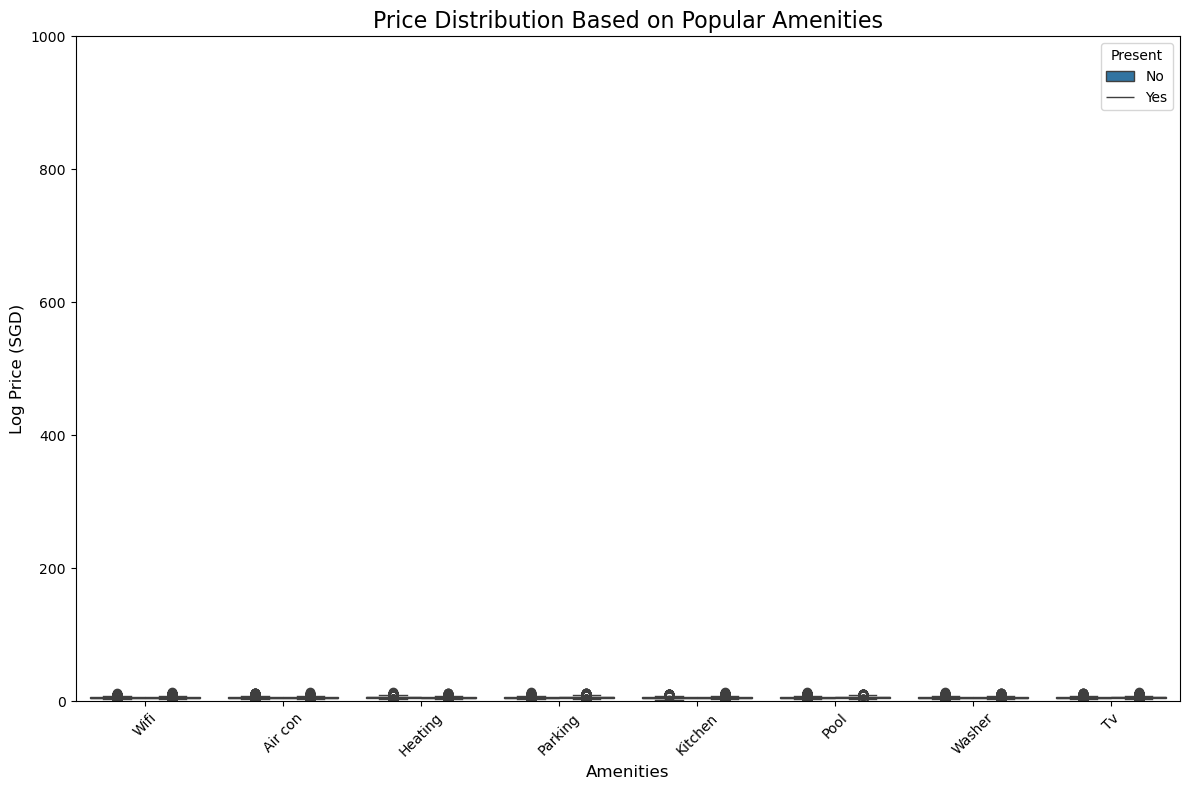

In [56]:
def visualize_summary_price_vs_amenities(df, price_column, popular_amenities):
    # Filter out listings with price_sgd < 10
    df = df[df[price_column] >= 10]

    # Step 2: Apply log transformation to the price column
    df['log_price_sgd'] = np.log(df[price_column] + 1)  # Add 1 to avoid log(0)
    
    # Step 1: Melt the DataFrame to long format for plotting
    df_melted = df.melt(id_vars=['log_price_sgd'], 
                        value_vars=[f'{amenity}_present' for amenity in popular_amenities],
                        var_name='amenity', 
                        value_name='present')
    
    # Step 2: Replace binary column names with readable amenity names
    df_melted['amenity'] = df_melted['amenity'].str.replace('_present', '').str.replace('_', ' ').str.capitalize()
    
    # Step 3: Create the boxplot
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='amenity', y='log_price_sgd', hue='present', data=df_melted)
    
    # Customize the plot
    plt.title('Price Distribution Based on Popular Amenities', fontsize=16)
    plt.xlabel('Amenities', fontsize=12)
    plt.ylabel('Log Price (SGD)', fontsize=12)
    plt.ylim(0, 1000)  # Limit the y-axis to focus on the distribution
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend(title='Present', loc='upper right', labels=['No', 'Yes'])
    plt.tight_layout()
    plt.show()

# Call the summary visualization function:
visualize_summary_price_vs_amenities(df, 'price_sgd', popular_amenities)

In [57]:
# def visualize_summary_price_vs_amenities_by_city(df, price_column, city_column, popular_amenities):
#     # Loop through each unique city and create a separate plot
#     for city in df[city_column].unique():
#         # Filter the DataFrame for the current city
#         df_city = df[df[city_column] == city]

#         # Step 1: Melt the DataFrame to long format for plotting
#         df_melted = df_city.melt(id_vars=[price_column], 
#                                  value_vars=[f'{amenity}_present' for amenity in popular_amenities],
#                                  var_name='amenity', 
#                                  value_name='present')
        
#         # Step 2: Replace binary column names with readable amenity names
#         df_melted['amenity'] = df_melted['amenity'].str.replace('_present', '').str.replace('_', ' ').str.capitalize()

#         # Step 3: Create the boxplot for the current city
#         plt.figure(figsize=(12, 6))
#         sns.boxplot(x='amenity', y=price_column, hue='present', data=df_melted)
        
#         # Customize the plot
#         plt.title(f'Price Distribution Based on Popular Amenities in {city}', fontsize=16)
#         plt.xlabel('Amenities', fontsize=12)
#         plt.ylabel('Price (SGD)', fontsize=12)
#         if city == 'Mexico':
#            plt.ylim(0, 3000)
#         elif city == 'Rio de Janeiro': 
#             plt.ylim(0, 2000)
#         else:
#             plt.ylim(0, 1000)
#         plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#         plt.legend(title='Present', loc='upper right', labels=['No', 'Yes'])
#         plt.tight_layout()
#         plt.show()

# # Call the summary visualization function for separate city plots:
# visualize_summary_price_vs_amenities_by_city(df_popular, 'price_sgd', 'City', popular_amenities)



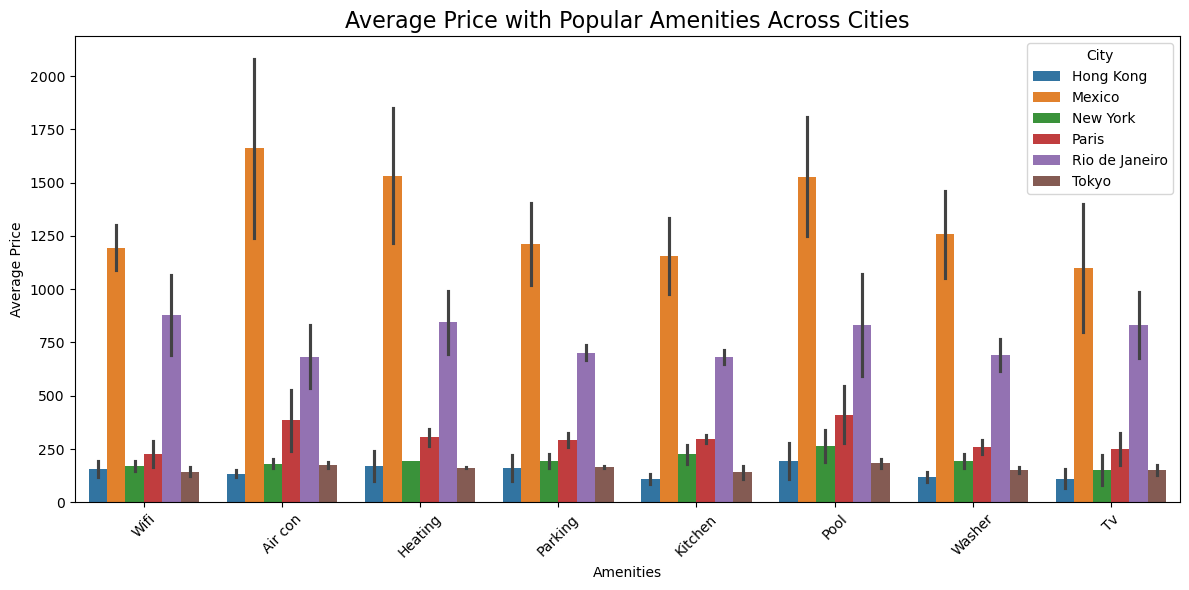

In [58]:
def grouped_bar_chart(df, city_column, price_column, popular_amenities):
    # Create a list to collect all data for grouped bar chart
    bar_data = []

    for amenity in popular_amenities:
        # Group by city and presence of the amenity, calculate mean price
        summary = df.groupby([city_column, f'{amenity}_present'])[price_column].mean().unstack()
        summary = summary.reset_index()  # Reset index to ensure 'city' remains a column
        summary['amenity'] = amenity.capitalize()  # Add amenity label
        bar_data.append(summary)  # Append summary to list

    # Concatenate all data into one DataFrame
    bar_data = pd.concat(bar_data).reset_index(drop=True)

    # Melt the DataFrame to get it in long format for easy plotting
    bar_data_melted = bar_data.melt(id_vars=[city_column, 'amenity'], value_name=price_column, var_name='present')

    # Plot a grouped bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x='amenity', y=price_column, hue=city_column, data=bar_data_melted)
    # sns.barplot(x=city_column, y=price_column, hue='amenity', data=bar_data_melted)

    # Customize the plot
    plt.title('Average Price with Popular Amenities Across Cities', fontsize=16)
    plt.xlabel('Amenities')
    plt.ylabel('Average Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='City')
    plt.show()

# Assuming the city column is called 'city' and price column is 'price_sgd'
grouped_bar_chart(df_popular, 'City', 'price_sgd', popular_amenities)


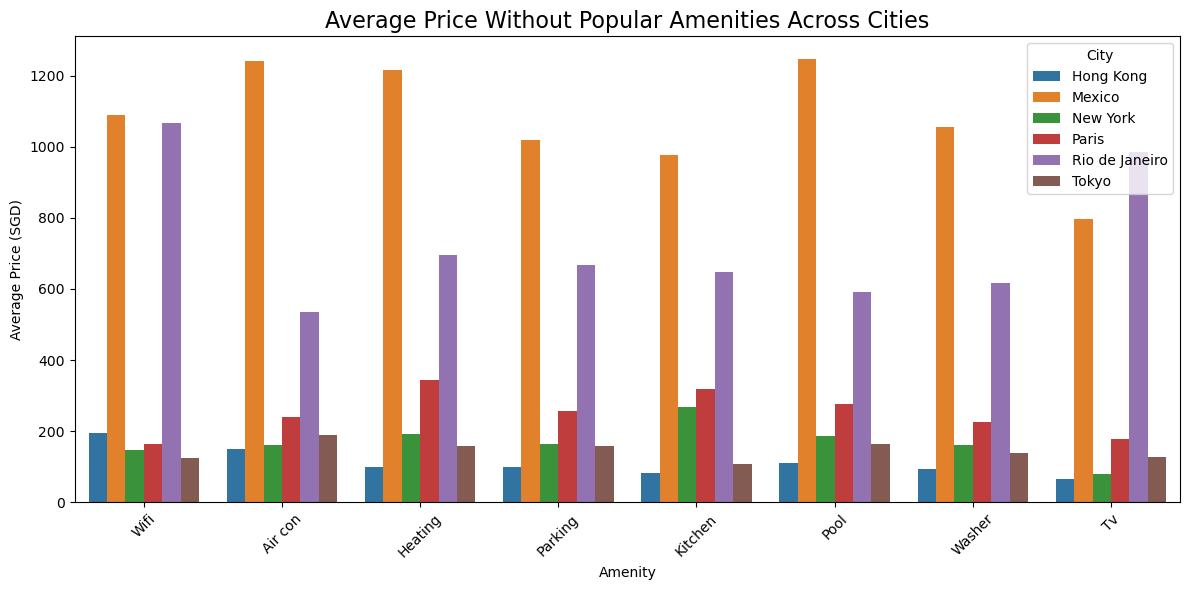

In [59]:
def grouped_bar_chart_without_amenities(df, city_column, price_column, popular_amenities):
    # Create a list to collect all data for grouped bar chart
    bar_data = []

    for amenity in popular_amenities:
        # Group by city and 'not present' for the amenity, calculate mean price
        summary = df[df[f'{amenity}_present'] == 0].groupby([city_column])[price_column].mean().reset_index()
        summary['amenity'] = amenity.capitalize()  # Add amenity label
        bar_data.append(summary)  # Append summary to list

    # Concatenate all data into one DataFrame
    bar_data = pd.concat(bar_data).reset_index(drop=True)

    # Plot a grouped bar chart with cities and amenities as factors
    plt.figure(figsize=(12, 6))
    sns.barplot(x='amenity', y=price_column, hue=city_column, data=bar_data)

    # Customize the plot
    plt.title('Average Price Without Popular Amenities Across Cities', fontsize=16)
    plt.xlabel('Amenity')
    plt.ylabel('Average Price (SGD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='City')
    plt.show()

# Call the updated function to plot listings without amenities
grouped_bar_chart_without_amenities(df_popular, 'City', 'price_sgd', popular_amenities)


#### Two-Way ANOVA: Wi-Fi and TV Impact on Prices

ANOVA Table (Before Removing Outliers):
                                     sum_sq      df           F        PR(>F)
C(wifi_present)                   1.065592     1.0    1.087144  2.971709e-01
C(tv_present)                   231.278155     1.0  235.955991  1.028824e-51
C(wifi_present):C(tv_present)     1.723946     1.0    1.758815  1.848519e-01
Residual                       3737.407141  3813.0         NaN           NaN


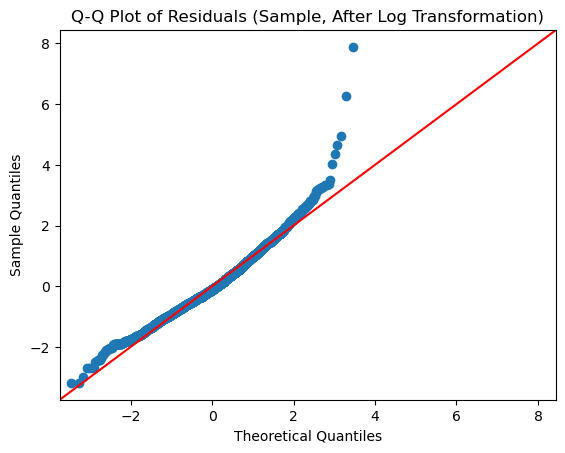

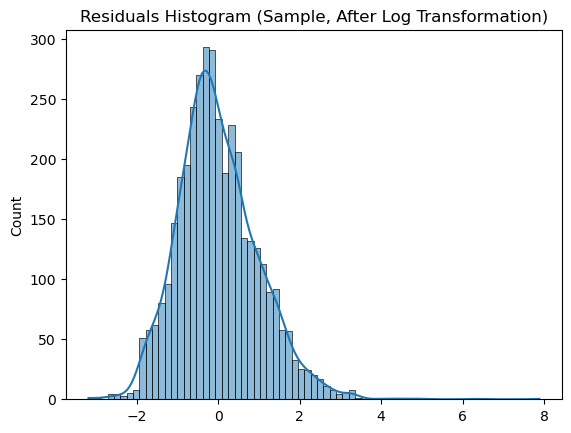

c:\Users\leeze\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning:

invalid value encountered in divide



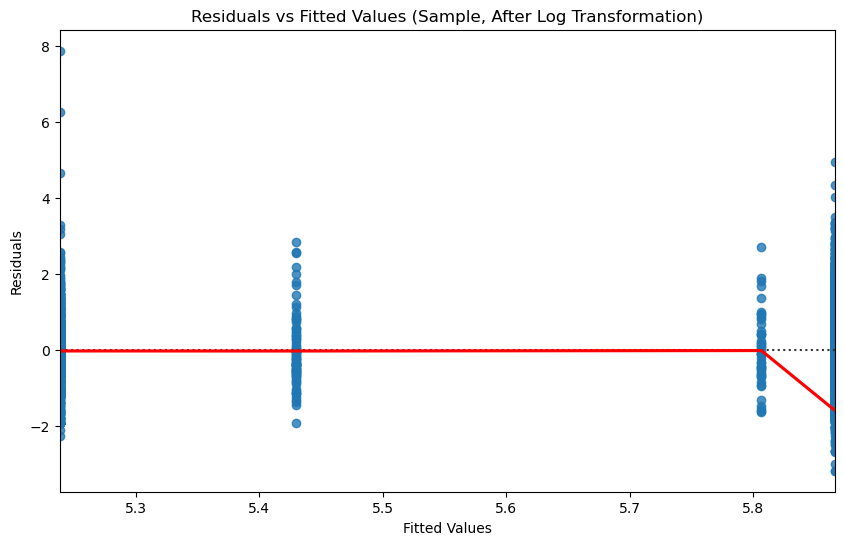

Number of outliers detected: 24
ANOVA Table (After Removing Outliers):
                                     sum_sq      df           F        PR(>F)
C(wifi_present)                   1.838561     1.0    2.070754  1.502299e-01
C(tv_present)                   247.505075     1.0  278.762687  1.922344e-60
C(wifi_present):C(tv_present)     2.082996     1.0    2.346060  1.256836e-01
Residual                       3364.140082  3789.0         NaN           NaN


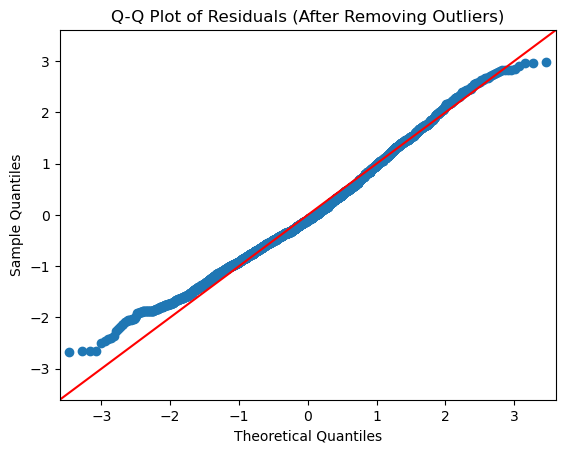

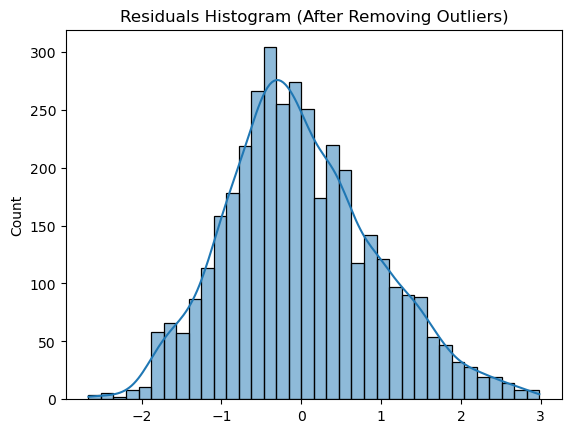

c:\Users\leeze\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning:

invalid value encountered in divide



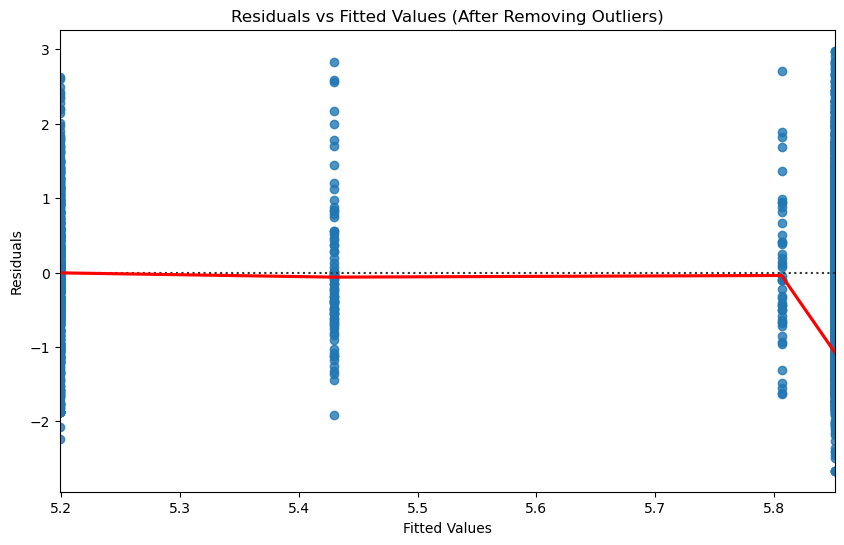

In [60]:
# Step 1: Take a random sample of 5000 rows from the dataset
df_sample = df.sample(n=5000, random_state=42)

# Filter out listings with price_sgd < 10
df_sample = df_sample[df_sample['price_sgd'] >= 10]
# Step 2: Apply log transformation to the price column
df_sample['log_price_sgd'] = np.log(df_sample['price_sgd'] + 1)  # Add 1 to avoid log(0)

# Step 3: Fit the Two-Way ANOVA model using the log-transformed price
model_log = ols('log_price_sgd ~ C(wifi_present) + C(tv_present) + C(wifi_present):C(tv_present)', data=df_sample).fit()

# Step 4: Perform the Two-Way ANOVA
anova_table_log = sm.stats.anova_lm(model_log, typ=2)
print('ANOVA Table (Before Removing Outliers):\n', anova_table_log)

# Step 5: Check residuals for normality using Q-Q plot
sm.qqplot(model_log.resid, line='45')
plt.title('Q-Q Plot of Residuals (Sample, After Log Transformation)')
plt.show()

# Step 6: Plot a histogram of residuals
sns.histplot(model_log.resid, kde=True)
plt.title('Residuals Histogram (Sample, After Log Transformation)')
plt.show()

# Step 7: Check for heteroscedasticity with residuals vs fitted values plot
plt.figure(figsize=(10, 6))
sns.residplot(x=model_log.fittedvalues, y=model_log.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs Fitted Values (Sample, After Log Transformation)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Step 8: Detect and Remove Outliers using Z-score (Z > 3 or Z < -3)
df_sample['residuals'] = model_log.resid
df_sample['z_score'] = np.abs(stats.zscore(df_sample['residuals']))

# Detect outliers where Z-score > 3
outliers = df_sample[df_sample['z_score'] > 3]
print(f"Number of outliers detected: {len(outliers)}")

# Remove the outliers from the sample
df_no_outliers = df_sample[df_sample['z_score'] <= 3]

# Step 9: Re-fit the Two-Way ANOVA model without outliers
model_no_outliers = ols('log_price_sgd ~ C(wifi_present) + C(tv_present) + C(wifi_present):C(tv_present)', data=df_no_outliers).fit()

# Step 10: Perform the Two-Way ANOVA after removing outliers
anova_no_outliers = sm.stats.anova_lm(model_no_outliers, typ=2)
print('ANOVA Table (After Removing Outliers):\n', anova_no_outliers)

# Step 11: Check residuals again for normality using Q-Q plot (after removing outliers)
sm.qqplot(model_no_outliers.resid, line='45')
plt.title('Q-Q Plot of Residuals (After Removing Outliers)')
plt.show()

# Step 12: Plot a histogram of residuals after removing outliers
sns.histplot(model_no_outliers.resid, kde=True)
plt.title('Residuals Histogram (After Removing Outliers)')
plt.show()

# Step 13: Check for heteroscedasticity with residuals vs fitted values plot (after removing outliers)
plt.figure(figsize=(10, 6))
sns.residplot(x=model_no_outliers.fittedvalues, y=model_no_outliers.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs Fitted Values (After Removing Outliers)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


#### Two-Way ANOVA with City and Pool Impact on Prices


ANOVA Table (Before Removing Outliers):
                                sum_sq      df           F         PR(>F)
C(City)                   4944.488579     5.0  178.482030  2.959249e-175
C(pool_present)            163.120881     1.0   29.441008   6.036908e-08
C(City):C(pool_present)     22.662176     5.0    0.818040   5.365672e-01
Residual                 27636.517838  4988.0         NaN            NaN


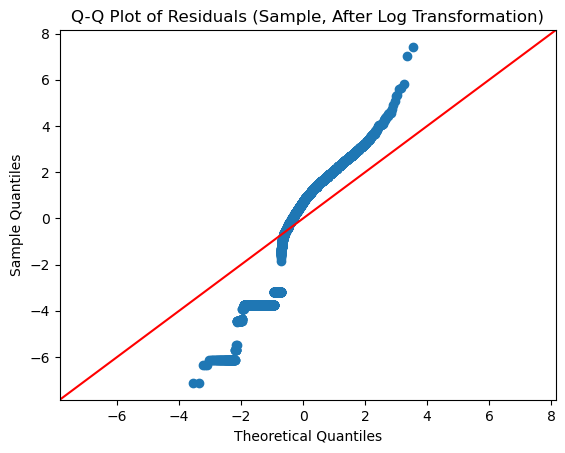

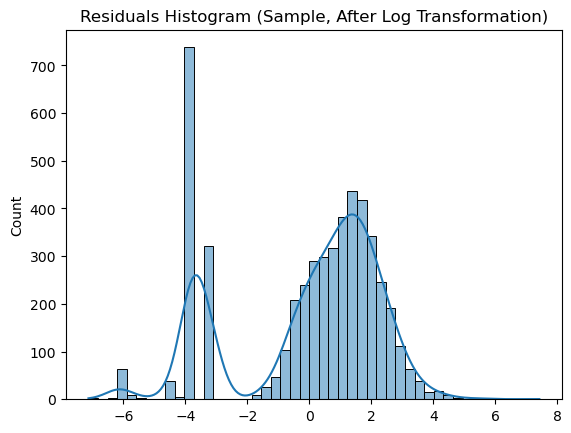

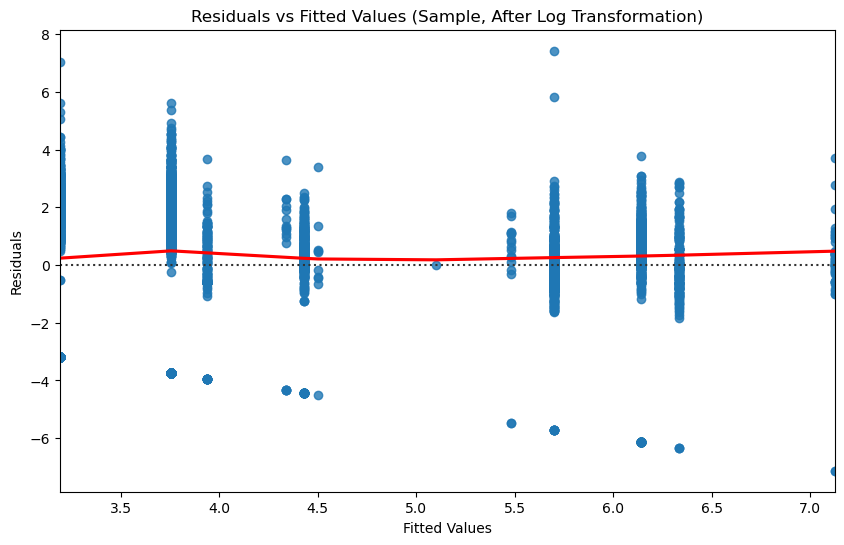

Number of outliers detected: 3
ANOVA Table (After Removing Outliers):
                                sum_sq      df           F         PR(>F)
C(City)                   4941.666893     5.0  179.314164  5.200230e-176
C(pool_present)            186.841619     1.0   33.898834   6.168757e-09
C(City):C(pool_present)     28.812491     5.0    1.045495   3.888903e-01
Residual                 27476.032971  4985.0         NaN            NaN


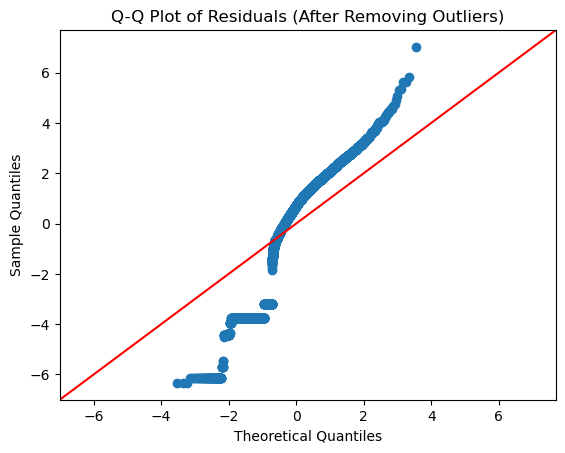

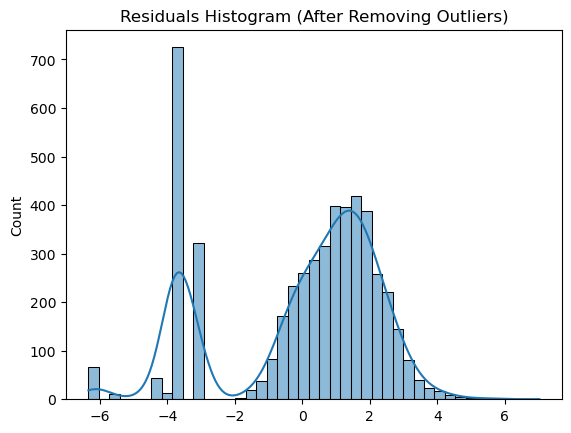

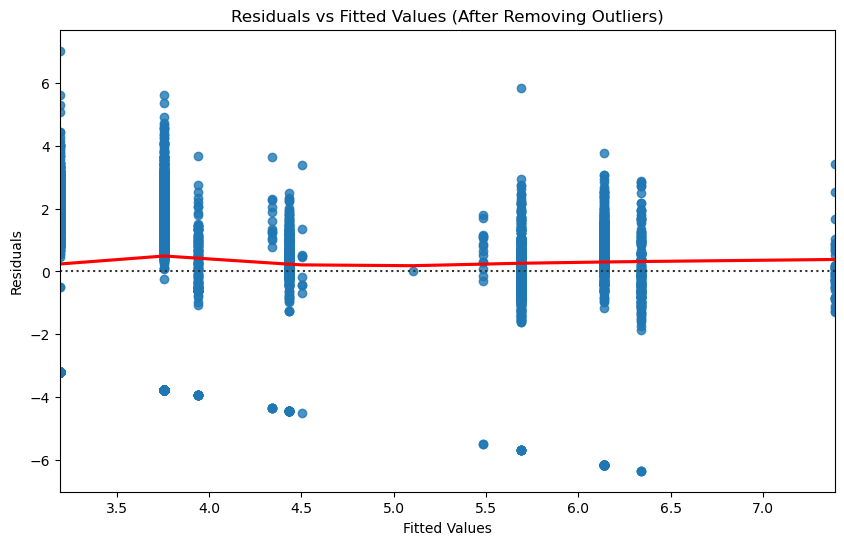

In [61]:
# Step 1: Take a random sample of 5000 rows from the dataset
df_sample = df.sample(n=5000, random_state=42)

# Step 2: Apply log transformation to the price column
df_sample['log_price_sgd'] = np.log(df_sample['price_sgd'] + 1)  # Add 1 to avoid log(0)

# Step 3: Fit the Two-Way ANOVA model using the log-transformed price
model_log = ols('log_price_sgd ~ C(City) + C(pool_present) + C(City):C(pool_present)', data=df_sample).fit()

# Step 4: Perform the Two-Way ANOVA
anova_table_log = sm.stats.anova_lm(model_log, typ=2)
print('ANOVA Table (Before Removing Outliers):\n', anova_table_log)

# Step 5: Check residuals for normality using Q-Q plot
sm.qqplot(model_log.resid, line='45')
plt.title('Q-Q Plot of Residuals (Sample, After Log Transformation)')
plt.show()

# Step 6: Plot a histogram of residuals
sns.histplot(model_log.resid, kde=True)
plt.title('Residuals Histogram (Sample, After Log Transformation)')
plt.show()

# Step 7: Check for heteroscedasticity with residuals vs fitted values plot
plt.figure(figsize=(10, 6))
sns.residplot(x=model_log.fittedvalues, y=model_log.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs Fitted Values (Sample, After Log Transformation)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Step 8: Detect and Remove Outliers using Z-score (Z > 3 or Z < -3)
df_sample['residuals'] = model_log.resid
df_sample['z_score'] = np.abs(stats.zscore(df_sample['residuals']))

# Detect outliers where Z-score > 3
outliers = df_sample[df_sample['z_score'] > 3]
print(f"Number of outliers detected: {len(outliers)}")

# Remove the outliers from the sample
df_no_outliers = df_sample[df_sample['z_score'] <= 3]

# Step 9: Re-fit the Two-Way ANOVA model without outliers
model_no_outliers = ols('log_price_sgd ~ C(City) + C(pool_present) + C(City):C(pool_present)', data=df_no_outliers).fit()

# Step 10: Perform the Two-Way ANOVA after removing outliers
anova_no_outliers = sm.stats.anova_lm(model_no_outliers, typ=2)
print('ANOVA Table (After Removing Outliers):\n', anova_no_outliers)

# Step 11: Check residuals again for normality using Q-Q plot (after removing outliers)
sm.qqplot(model_no_outliers.resid, line='45')
plt.title('Q-Q Plot of Residuals (After Removing Outliers)')
plt.show()

# Step 12: Plot a histogram of residuals after removing outliers
sns.histplot(model_no_outliers.resid, kde=True)
plt.title('Residuals Histogram (After Removing Outliers)')
plt.show()

# Step 13: Check for heteroscedasticity with residuals vs fitted values plot (after removing outliers)
plt.figure(figsize=(10, 6))
sns.residplot(x=model_no_outliers.fittedvalues, y=model_no_outliers.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs Fitted Values (After Removing Outliers)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


In [62]:
from statsmodels.graphics.factorplots import interaction_plot

# Create an interaction plot
plt.figure(figsize=(10, 6))
interaction_plot(df['City'], df['pool_present'], df['log_price_sgd'],
                 colors=['blue', 'orange'], markers=['D', '^'], ms=10)

plt.title('Interaction Plot: City and Pool Presence on Price')
plt.xlabel('City')
plt.ylabel('Log Mean Price (SGD)')
plt.show()

KeyError: 'log_price_sgd'

<Figure size 1000x600 with 0 Axes>

### Average price by amenities category

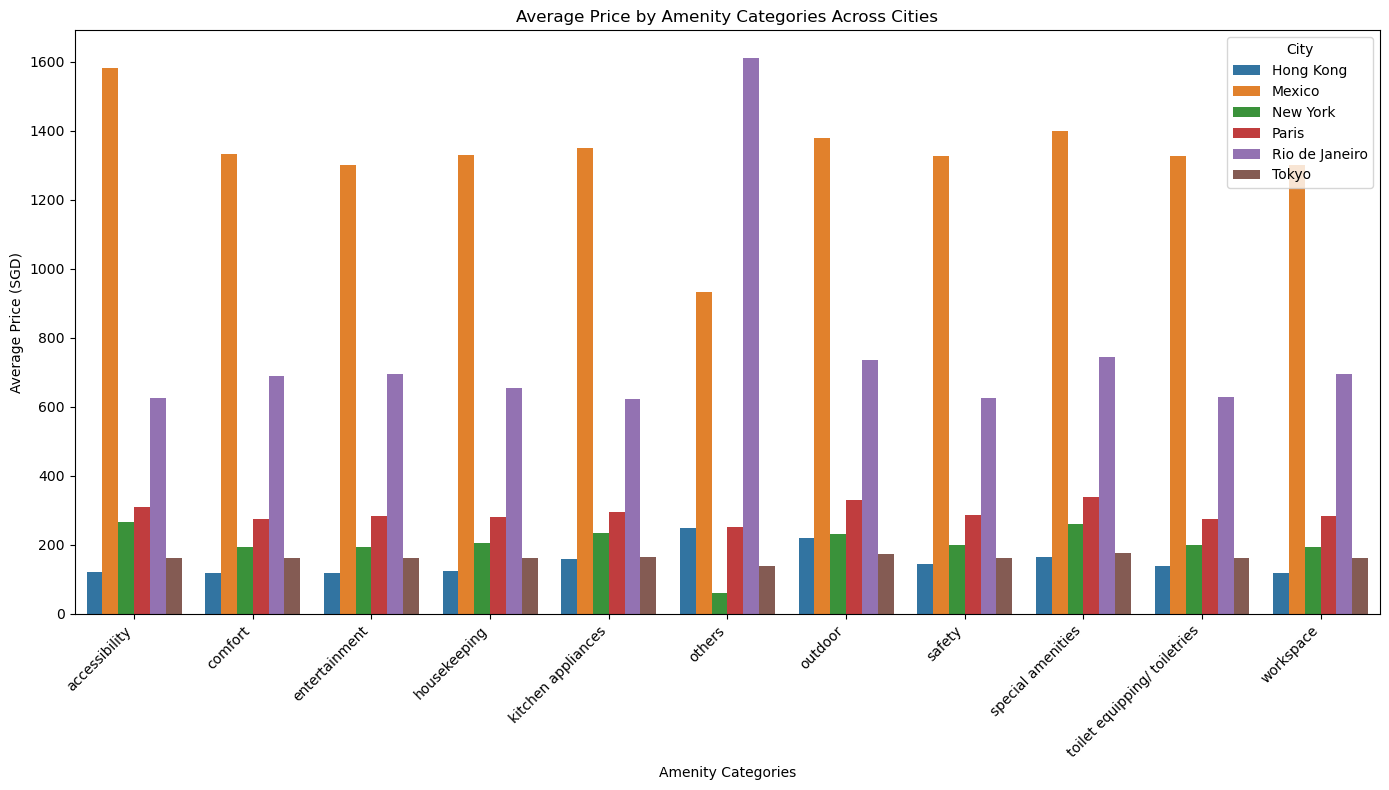

In [78]:
# Step 1: Explode the 'amenity_categories' so each row contains only one amenity
df_exploded = df.explode('amenity_categories')

# Step 2: Group by both 'City' and 'amenity_categories' to calculate the average price
price_by_city_amenity = df_exploded.groupby(['City', 'amenity_categories'], as_index=False)['price_sgd'].mean()

# Step 3: Create a single plot with all cities, differentiated by color
plt.figure(figsize=(14, 8))
sns.barplot(data=price_by_city_amenity, x='amenity_categories', y='price_sgd', hue='City')

# Customize the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel('Amenity Categories')
plt.ylabel('Average Price (SGD)')
plt.title('Average Price by Amenity Categories Across Cities')
plt.legend(title='City')  # Add a legend to differentiate the cities
plt.tight_layout()

# Show the plot
plt.show()

In [79]:
# Check the number of listings for each city
print(df['City'].value_counts())

print(df_exploded['price_sgd'].isnull().sum())

City
Paris             95461
New York          37541
Rio de Janeiro    34664
Mexico            26536
Tokyo             16518
Hong Kong          6627
Name: count, dtype: int64
0


### Correlation analysis (price, review scores rating, categories of amenities) 

Correlations with price (SGD):
price_sgd                       1.000000
review_scores_rating           -0.022547
accessibility                   0.020797
comfort                        -0.015216
entertainment                   0.003459
housekeeping                   -0.005785
kitchen appliances              0.016852
outdoor                         0.054978
safety                         -0.014277
special amenities               0.045192
toilet equipping/ toiletries   -0.006794
workspace                       0.003614
Name: price_sgd, dtype: float64


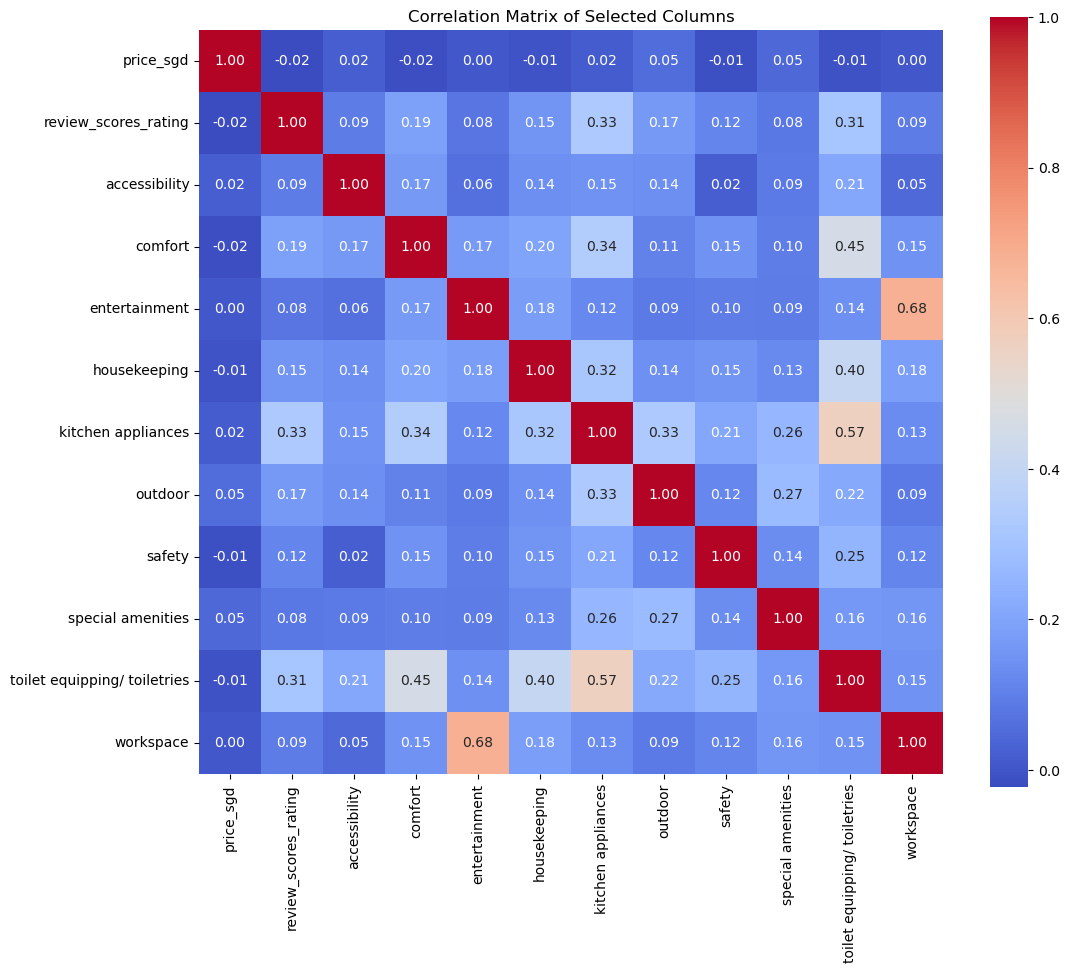

In [80]:
# Assuming df and grouped_amenities are already defined

# Step 1: Explode the 'amenity_categories' so each row contains only one amenity
exploded_data = df.explode('amenity_categories')

# Step 2: Create dummy variables for each amenity category, excluding 'others'
amenities_dummies = pd.get_dummies(exploded_data['amenity_categories']).drop(columns=['others'], errors='ignore')

# Step 3: Group the exploded data back by its original index and sum the dummy variables
grouped_amenities = amenities_dummies.groupby(exploded_data.index).sum()

# Step 4: Merge the grouped dummy variables with the original data, avoiding duplicate columns
data_with_dummies = pd.concat([df.drop(columns=grouped_amenities.columns, errors='ignore'), grouped_amenities], axis=1)

# Step 5: Select only the columns of interest for correlation (price_sgd, review_scores_rating, and amenities)
columns_of_interest = ['price_sgd', 'review_scores_rating'] + list(grouped_amenities.columns)

# Step 6: Calculate correlations only for the selected columns
correlations = data_with_dummies[columns_of_interest].corr()

# Step 7: Extract correlations with 'price_sgd' and 'review_scores_rating'
price_correlations = correlations['price_sgd']
review_score_correlations = correlations['review_scores_rating']

# Sort the columns alphabetically, keeping 'price_sgd' and 'review_scores_rating' as the top rows
sorted_columns = ['price_sgd', 'review_scores_rating'] + sorted([col for col in correlations.columns if col not in ['price_sgd', 'review_scores_rating']])

# Reindex the correlation matrix to match the sorted columns
sorted_correlations = correlations.reindex(sorted_columns, axis=1).reindex(sorted_columns, axis=0)

# Display the correlations
print("Correlations with price (SGD):")
print(sorted_correlations['price_sgd'])

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(sorted_correlations, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title('Correlation Matrix of Selected Columns')
plt.show()

C:\Users\leeze\AppData\Local\Temp\ipykernel_25700\2436175896.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_per_cohort_city = data_with_dummies.groupby(['City', 'amenity_group'], as_index=False)['price_sgd'].mean()


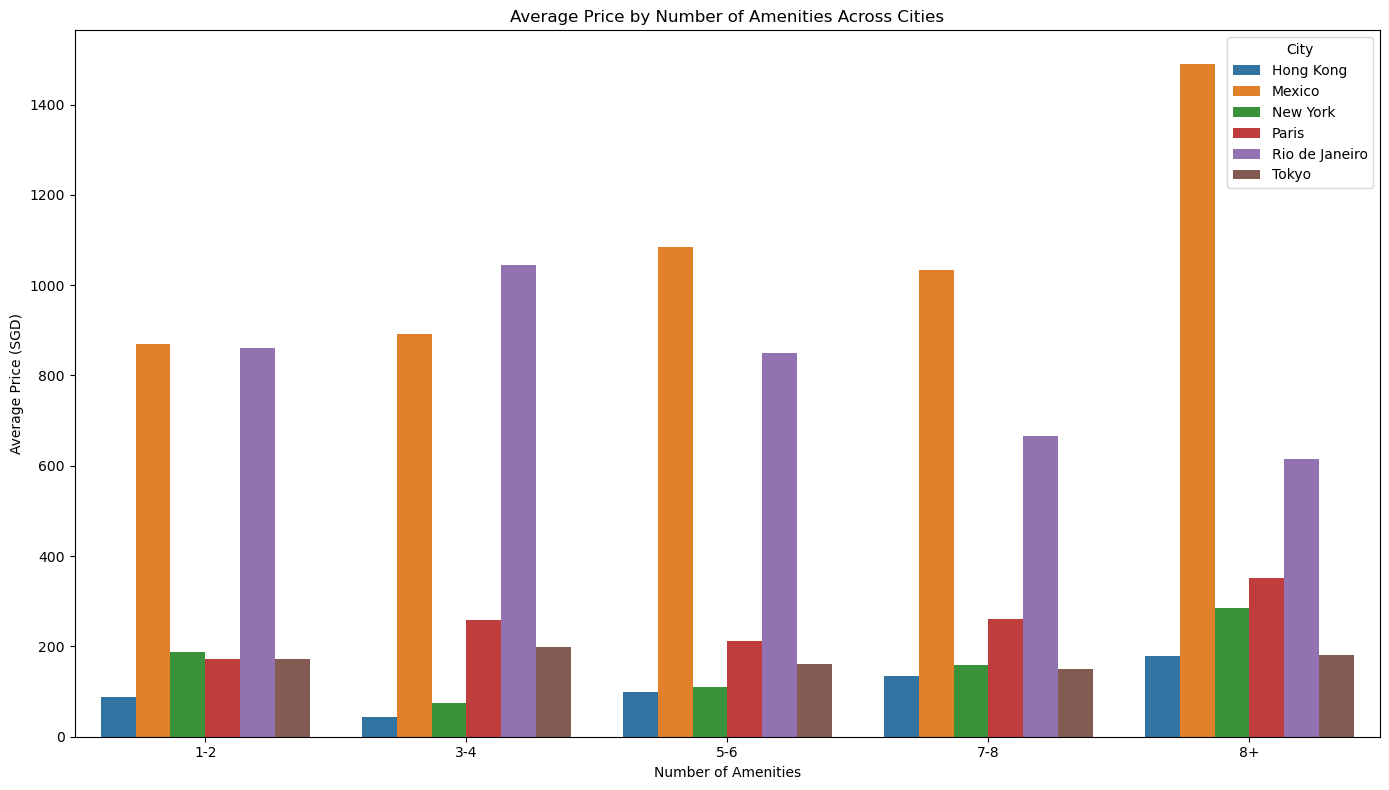

In [81]:
# Calculate the total number of amenities for each listing
data_with_dummies['total_amenities'] = grouped_amenities.sum(axis=1)

# Group listings into cohorts based on the number of amenities
data_with_dummies['amenity_group'] = pd.cut(data_with_dummies['total_amenities'], bins=[0, 2, 4, 6, 8, float('inf')], labels=['1-2', '3-4', '5-6', '7-8', '8+'])

# Group by both City and amenity_group to calculate the average price
avg_price_per_cohort_city = data_with_dummies.groupby(['City', 'amenity_group'], as_index=False)['price_sgd'].mean()

# Plot the data using Seaborn barplot, with 'City' as hue
plt.figure(figsize=(14, 8))
sns.barplot(data=avg_price_per_cohort_city, x='amenity_group', y='price_sgd', hue='City')

# Customize the plot
plt.xlabel('Number of Amenities')
plt.ylabel('Average Price (SGD)')
plt.title('Average Price by Number of Amenities Across Cities')
plt.legend(title='City')
plt.tight_layout()

# Show the plot
plt.show()